In [1]:
import processing.scales
from scripts.viz_utils import *

data = pd.read_csv('../data/data_scales.csv', index_col='ResponseId')
plots_path = '../plots/manip_check'

In [2]:
manip_check_scales = processing.scales.manip_check_scales

titles = ["The MDSS makes medical decisions independently",
          "The MDSS will give a correct diagnosis\nin 9 out of 10 cases",
          "The MDSS indicates exactly, how high\nthe probability for a given diagnosis is",
          "The doctors at the hospital know how the MDSS works"]

titles_short = ['independent dec.', 'correct 9/10 times', 'exact probability', 'doctors know']

['manip_check1_1', 'manip_check1_2', 'manip_check1_3']

Statistical Test Results for 'manip_check1_1':
  Group Descriptive Statistics:
    control: n = 126, M = 2.30, SD = 1.26
    uncertainty: n = 129, M = 2.19, SD = 1.10
  Test: Mann-Whitney U test (non-parametric)
  Result: U = 8332.00, p = .717, r = -0.03
  Interpretation: not significant (p ≥ .05)


Statistical Test Results for 'manip_check1_2':
  Group Descriptive Statistics:
    control: n = 126, M = 4.02, SD = 1.00
    uncertainty: n = 129, M = 3.34, SD = 0.98
  Test: Mann-Whitney U test (non-parametric)
  Result: U = 11243.00, p < .001, r = -0.38
  Interpretation: highly significant (p < .001)


Statistical Test Results for 'manip_check1_3':
  Group Descriptive Statistics:
    control: n = 126, M = 3.85, SD = 1.03
    uncertainty: n = 129, M = 3.20, SD = 1.25
  Test: Mann-Whitney U test (non-parametric)
  Result: U = 10513.50, p < .001, r = -0.29
  Interpretation: highly significant (p < .001)



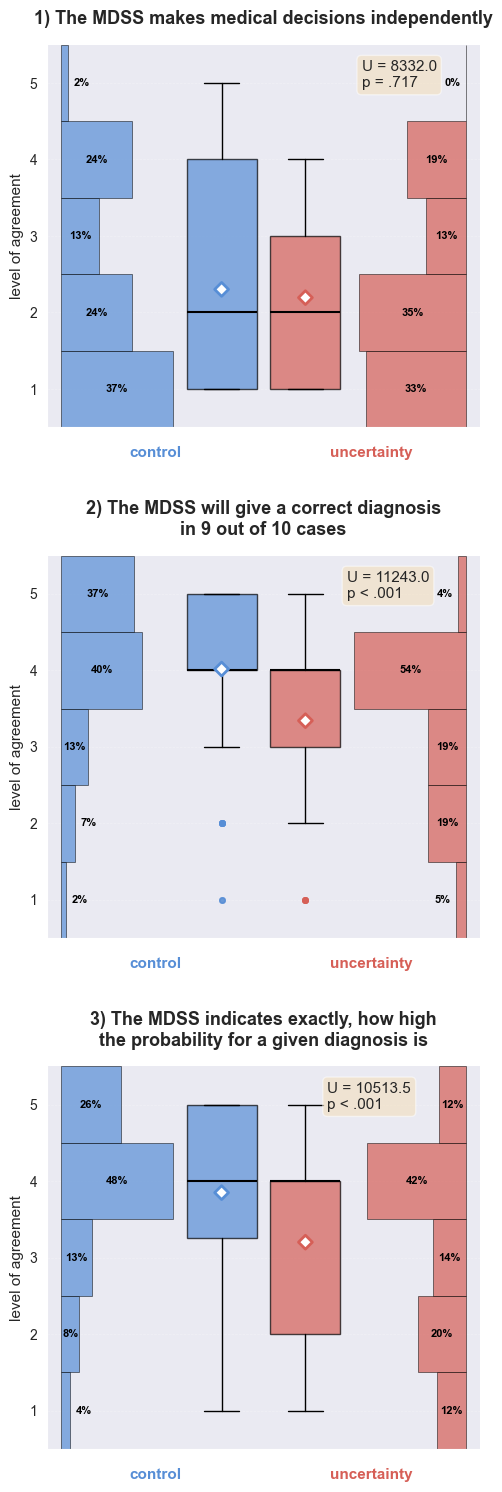

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))

print(manip_check_scales[:-1])

for (i, scale)  in enumerate(manip_check_scales[:-1]):
    axs[i] = plot_split_histogram_boxplot(data, scale, group_by='stimulus_group',
                             title=f'{i+1}) {titles[i]}',
                             ylabel='level of agreement', show_counts=False,
                             test_method='nonparametric',
                             ax=axs[i])

plt.tight_layout(h_pad=3)
plt.savefig(f'{plots_path}/manip_checks.png', transparent=True)
plt.show()

In [4]:
# relative number of languages used by participants
counts = data['UserLanguage'].value_counts()

languages = pd.DataFrame(counts)
total = np.sum(counts)

languages['percent'] = np.round(counts/total, 4) * 100

print(languages)


              count  percent
UserLanguage                
NL              160    62.75
DE               48    18.82
EN-GB            47    18.43



Multiple Item Comparison: manip_check1_1, manip_check1_2, manip_check1_3

Statistical Test Results for 'manip_check1_1':
  Group Descriptive Statistics:
    DE: n = 27, M = 2.15, SD = 0.99
    EN-GB: n = 23, M = 2.09, SD = 1.04
    NL: n = 79, M = 2.24, SD = 1.16
  Test: Kruskal-Wallis H test (non-parametric)
  Result: H(2) = 0.20, p = .906
  Interpretation: not significant (p ≥ .05)


Statistical Test Results for 'manip_check1_2':
  Group Descriptive Statistics:
    DE: n = 27, M = 3.48, SD = 0.94
    EN-GB: n = 23, M = 3.09, SD = 1.04
    NL: n = 79, M = 3.37, SD = 0.98
  Test: Kruskal-Wallis H test (non-parametric)
  Result: H(2) = 2.03, p = .363
  Interpretation: not significant (p ≥ .05)


Statistical Test Results for 'manip_check1_3':
  Group Descriptive Statistics:
    DE: n = 27, M = 3.41, SD = 1.25
    EN-GB: n = 23, M = 3.39, SD = 1.53
    NL: n = 79, M = 3.08, SD = 1.15
  Test: Kruskal-Wallis H test (non-parametric)
  Result: H(2) = 3.09, p = .214
  Interpretation: not sign

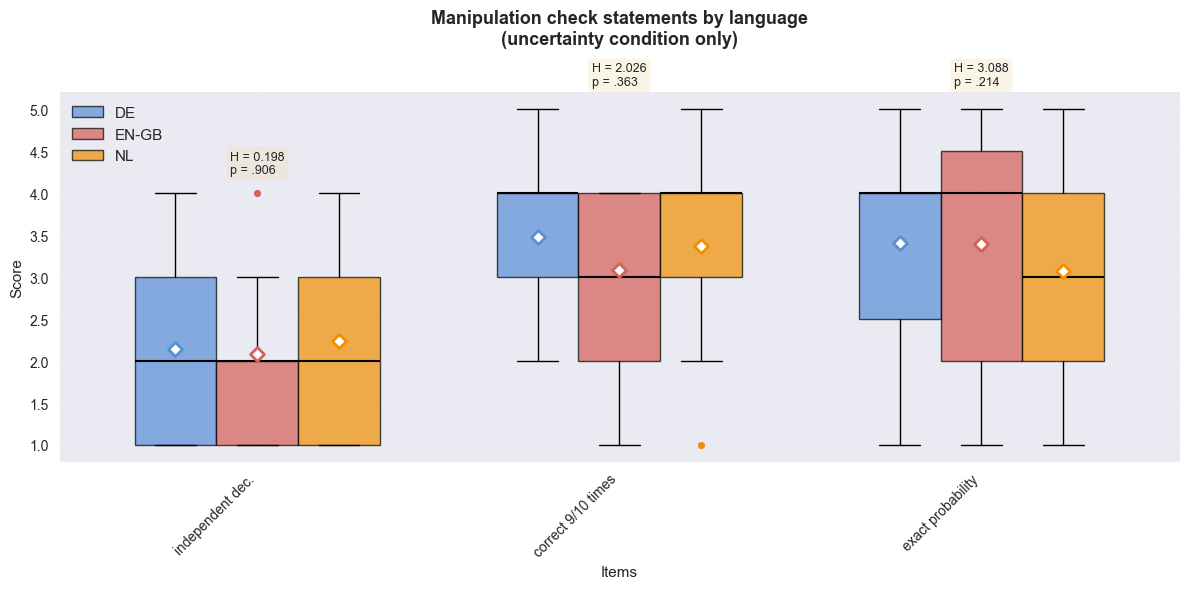

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = plot_boxplot(data[data['stimulus_group'] == 1], manip_check_scales[:-1],
                 group_by='UserLanguage',
                 title='Manipulation check statements by language\n(uncertainty condition only)',
                 short_labels=titles_short[:-1],
                 ax=ax,
                 show_mean=True, test_method='nonparametric')

plt.tight_layout()
plt.savefig(f'{plots_path}/manip_check_unc_lang.png', transparent=True)
plt.show()

In [6]:
# compute correlation between statements 2 and 3
rho_con, p_con = spearman_correlation(data[manip_check_scales[1]][data['stimulus_group'] == 0],
                                      data[manip_check_scales[2]][data['stimulus_group'] == 0])

rho_unc, p_unc = spearman_correlation(data[manip_check_scales[1]][data['stimulus_group'] == 1],
                                      data[manip_check_scales[2]][data['stimulus_group'] == 1])

print(f'Spearman correlation between statements 2 and 3\n'
      f'Control group:\t\t rho={rho_con:.3f}, p={p_con:.3f}\n'
      f'Uncertainty group:\t rho={rho_unc:.3f}, p={p_unc:.3f}\n')

# Create simplified scores: 1-2 = Disagree, 3 = Neither, 4-5 = Agree
def simplify_likert(value):
    """Recode 5-point Likert to 3-point categorical."""
    if pd.isna(value):
        return np.nan
    elif value <= 2:
        return 'Disagree'
    elif value == 3:
        return 'Neither'
    else:  # value >= 4
        return 'Agree'


# Create new dataframe with simplified scores
manip_check_simple = pd.DataFrame({
    'manip_check1_2_simple': data['manip_check1_2'].apply(simplify_likert),
    'manip_check1_3_simple': data['manip_check1_3'].apply(simplify_likert),
    'stimulus_group': data['stimulus_group']
}, index=data.index)

contingency_table_con = pd.crosstab(manip_check_simple['manip_check1_2_simple'][manip_check_simple['stimulus_group'] == 0],
                                    manip_check_simple['manip_check1_3_simple'][data['stimulus_group'] == 0],
                                    margins=True, normalize='index')

print('\nControl group:\n', contingency_table_con)

contingency_table_unc = pd.crosstab(manip_check_simple['manip_check1_2_simple'][manip_check_simple['stimulus_group'] == 1],
                                    manip_check_simple['manip_check1_3_simple'][data['stimulus_group'] == 1],
                                    margins=True, normalize='index')

print('\nUncertainty group:\n', contingency_table_unc)

Spearman correlation between statements 2 and 3
Control group:		 rho=0.308, p=0.000
Uncertainty group:	 rho=0.356, p=0.000


Control group:
 manip_check1_3_simple     Agree  Disagree   Neither
manip_check1_2_simple                              
Agree                  0.804124  0.103093  0.092784
Disagree               0.666667  0.250000  0.083333
Neither                0.470588  0.117647  0.411765
All                    0.746032  0.119048  0.134921

Uncertainty group:
 manip_check1_3_simple     Agree  Disagree   Neither
manip_check1_2_simple                              
Agree                  0.640000  0.200000  0.160000
Disagree               0.366667  0.600000  0.033333
Neither                0.416667  0.375000  0.208333
All                    0.534884  0.325581  0.139535
